<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Problems" data-toc-modified-id="Problems-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Problems</a></span></li></ul></li><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Some-useful-functions" data-toc-modified-id="Some-useful-functions-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Some useful functions</a></span></li><li><span><a href="#Creating-and-managing-a-standard-format-for-data-acquisition" data-toc-modified-id="Creating-and-managing-a-standard-format-for-data-acquisition-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Creating and managing a standard format for data acquisition</a></span></li></ul></li><li><span><a href="#Building-the-species-class" data-toc-modified-id="Building-the-species-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Building the species <code>class</code></a></span><ul class="toc-item"><li><span><a href="#Feature-request" data-toc-modified-id="Feature-request-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Feature request</a></span></li></ul></li><li><span><a href="#Load-CAM-database" data-toc-modified-id="Load-CAM-database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load CAM database</a></span></li></ul></div>

# database building
I've been working on combining data from many sources to do a comprehensive study of the morphology of different photosynthetic pathways. The hypothesized workflow is

1. Create a template spreadsheet to fill in data from a previous publication
2. Add collected data to a growing repository
3. Use database tools to correct taxonomy an merge data

This notebook is sandbox for database building. Some of the primary goals include

- Creating a standard format for data collection, input, and merging
    - Which data to include and exclude?
- Creating a standard unit of observaion
    - Current strategy is to use a species `class`
        - Could extend to taxonomically nested classes
        - Managing taxonomy across many decades of publications is an obvious hurdle but will attempt to resolve this with webscraping
- Figuring out a way to link crucial metadata, most importantly the source (publication) of the data, to the observations
    - Use [`bibtexparser`](https://bibtexparser.readthedocs.io/en/master/) to create a reference `class`
    
#### Problems
- How do we deal with metastudies? That is, how do we stop the duplicationof observations when one study uses and presents data from a previous study?
- Searching for intraspecific taxa is challenging because var. and subsp. are separate entities

### Dependencies
I'll be working in `conda` environment `photo_db`, and all dependencies can be installed with `conda`. To install new packages within the notebook, use

```python
!conda install --yes --prefix {sys.prefix} <package-name>
```

In [7]:
import numpy as np
import pandas as pd
import re, csv, os, sys, copy
import datetime
now = datetime.datetime.now()
from glob import glob
# Progress bar
try:
    from tqdm.auto import tqdm
except ModuleNotFoundError:
    print("Could not find module tqdm. Try installing with conda or pip.")
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="ticks")
# Citation management
import bibtexparser as bt
# missing data
import missingno as msno
# Web-scraping
import urllib3
import requests
from bs4 import BeautifulSoup

### Some useful functions

In [8]:
def mega_merge(dfs):
    '''Merges a list of pandas DataFrames into a single DataFrame
    
    Parameters
    ----------
    dfs <list> : a list of pandas DataFrames to merge'''
    
    return reduce(lambda left,right: pd.merge(left,right, how='outer'), dfs)

In [9]:
class Vividict(dict):
    '''An infinitely nestable dictionary'''
    def __missing__(self, key):
        value = self[key] = type(self)() # retain local pointer to value
        return value 

### Creating and managing a standard format for data acquisition
The main purpose of this project is to provide a platform to collect and management data about plant photosynthesis and morphology/physiology. After an initial literature review of ~60 papers I have settled on the 41 features below, which reflects features important in the determination of photosynthetic pathway.

These major types of features are
- taxonomy
    - `Family`, `Genus`, `Species`, `Subspecies
    - `Infradel` stands for "infraspecific delimiter", e.g. "subspecies" "variety"
    - `Taxon` is concatenation of `Genus`, `Species`, `Infradel`, and `Subspecies`, which is useful as a slicing indel
    - gaps in taxnomy can be filled using internal information with the `fill_taxonomy` function
- morphology (e.g. `FM_DM`, fresh mass:dry mass ratio; `IAS`, intercellular airspace fraction; and `leaf_thickness_um`, leaf thickness in $\mu m$)
- tissue type (`tissue`, which will almost invariably be leaves)
- ecology (`Habit`, mostly denoting if plants are terrestrial or epiphytic)
- physiology (`Pathway`, photosynthetic pathway used; `dC13`, carbon 13 isotope ratio)
- metadata (`CITEKEYS`, a unique reference identifier, which will be more clearly outlined in reference management, below)

The function below allows a user to generate a boilerplate `csv` to input observations of these features that ensures that users will collect **compatible** data and facilitates merging data later on identical columns. Of course, users can add more features as they see fit, but I hope this will encourage the use of overlapping features to reduce missing data downstream.

In [10]:
def create_photoDB_csv(output_path=None, no_csv = False, overwrite=False):
    '''Creates a boilerplate csv for collection of photosynthesis-related data
    
    Parameters
    ----------
    output_path <str> : path to csv to generate (default = None)
    no_csv <bool> : don't generate csv (default = False). Setting True will return an empty
        DataFrame, mostly a testing feature.
    overwrite <bool> : overwrite csv if it exists'''
    
    DB_COLUMNS = [u'Order', u'Family', u'Subfamily', u'Tribe', u'Subtribe', u'Genus', u'Species', u'Infradel', 
                  u'Subspecies', u'Taxon', u'Taxonomy_Status', u'Pathway', u'Pathway_subtype', u'dC13', 'Kranz_anatomy',
                  u'Kranz_subtype', u'BS_area_um2', u'FM_DM', u'FM_DM_sd', u'leaf_thickness_um', u'leaf_thickness_um_sd',
                  u'IAS', u'IAS_sd', u'SLA_cm2_g-1', u'SLA_cm2_g-1_sd', u'air_channel_area_um2', 
                  u'air_channel_area_um2_sd', u'chlorenchyma_diameter_um', u'chlorenchyma_diameter_um_sd', 
                  u'chlorenchyma_hydrenchyma_ratio', u'chlorenchyma_hydrenchyma_ratio_sd',
                  u'chlorenchyma_vertical_thickness_um', u'chlorenchyma_vertical_thickness_um_sd', 
                  u'distance_between_BS_um', u'hydrenchyma_vertical_thickness_um', u'hydrenchyma_vertical_thickness_um_sd',
                  u'mesophyll_area_um2', u'mesophyll_thickness_um', u'mesophyll_thickness_um_sd', u'BS:M',
                  u'mesophyll_cell_area_um2', u'vein_density_m_mm-2', u'Habit', u'tissue', "CITEKEYS"]
    
    new_db = pd.DataFrame(columns=DB_COLUMNS)
    
    if overwrite:
        if no_csv: return new_db    
        else: new_db.to_csv(path_or_buf=output_path, index=None)
    else:
        if os.path.exists(output_path):
            print("File {} already exists. Set overwrite=True to overwrite it.".format(output_path))
            return
        else:
            if no_csv: return new_db    
            else: new_db.to_csv(path_or_buf=output_path, index=None)

In [11]:
create_photoDB_csv(output_path="/Users/iangilman/Dropbox/GitHub_repos/photo_db/Data/Lundgren2020NP.csv")

In [6]:
def fill_taxa(df):
    '''Fills in the Taxon column for a photoDB dataframe by concatenating Genus, Species, Infradel,
    and Subspecies.
    
    Parameters
    ----------
    df <pandas DataFrame>: a photoDb formatted DataFrame'''
    
    copy = df.copy()
    for i, row in copy.reindex(columns=["Genus", "Species", "Infradel" "Subspecies"]).iterrows():
        copy.loc[i, "Taxon"] = ' '.join(list(row.fillna(""))).strip()
        
    return copy

In [55]:
arroyo = pd.read_csv("../Data/Arroyo1990BA.csv")
arroyo.head()

,Order,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,Pathway,BS_area_um2,...,mesophyll_adaxial_area_um2,mesophyll_adaxial_length_um,mesophyll_thickness_um,mesophyll_thickness_um_sd,mesophyll_cell_area_um2,Habit,dC13,tissue,Taxon,CITEKEYS
0,NaN,Montiaceae,NaN,NaN,NaN,Calandrinia,thyrsoidea,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.9,NaN,NaN,NaN
1,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,celosioides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-22.4,NaN,NaN,NaN
2,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,amaranthoides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.6,NaN,NaN,NaN
3,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,celosioides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-19.1,NaN,NaN,NaN
4,NaN,Portulacaceae,NaN,NaN,NaN,Portulaca,philippii,NaN,C4+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-12.1,NaN,NaN,NaN


In [56]:
fill_taxa(arroyo).head()

,Order,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,Pathway,BS_area_um2,...,mesophyll_adaxial_area_um2,mesophyll_adaxial_length_um,mesophyll_thickness_um,mesophyll_thickness_um_sd,mesophyll_cell_area_um2,Habit,dC13,tissue,Taxon,CITEKEYS
0,NaN,Montiaceae,NaN,NaN,NaN,Calandrinia,thyrsoidea,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.9,NaN,Calandrinia thyrsoidea,NaN
1,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,celosioides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-22.4,NaN,Cistanthe celosioides,NaN
2,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,amaranthoides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-21.6,NaN,Cistanthe amaranthoides,NaN
3,NaN,Montiaceae,NaN,NaN,NaN,Cistanthe,celosioides,NaN,C3+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-19.1,NaN,Cistanthe celosioides,NaN
4,NaN,Portulacaceae,NaN,NaN,NaN,Portulaca,philippii,NaN,C4+CAM,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-12.1,NaN,Portulaca philippii,NaN


## Building the species `class`
Choosing species as our database's atoms is attractive for a few reasons. Species are the basic units we're usually concerned with as biologists. We can associate multiple observations of the same species to build species trait distributions (e.g. range of leaf thicknesses) and combine disparate measurements (e.g. if one author measured $\delta C^{13}$ and another measured leaf thickness). Further, as taxonomy changes over time we'd like to make sure our measurements stay pinned to the underlying biological entity that was measured. We can associate synonyms and accepted taxonomy with species so that if two papers made measurements of the same organism but used two different taxonomies we can still merge those data.

We'll do all the taxonomy handling by web-scraping [The Plant List](http://www.theplantlist.org).
### Feature request
Instead of continuously querying The Plant List to resolve conflicts, it would be useful to use `pd.DataFrame.to_sql` to maintain a SQL database of the taxa in a local database. Whenever new taxa are added they would then be added to the local database and an update database function could be created to periodically check for taxonomic updates.

In [7]:
class Species:
    def __init__(self, genus, epithet="sp", infradel="", infra="", authority=None, status=None, 
                 order=None, family=None, subfamily=None, tribe=None, subtribe=None):
        self.order = order
        self.family = family
        self.subfamily = subfamily
        self.tribe = tribe
        self.subtribe = subtribe
        self.genus = genus
        self.epithet = epithet
        self.infradel = infradel
        self.infra = infra
        self.longname = ' '.join([self.genus, self.epithet, self.infradel, self.infra]).strip()
        self.authority = authority
        self.status = status
        
    def get_names(self, verbose = False):
        '''Queries theplantlist.org to check if the current species taxonomy is accepted,
        synonymous, or unresolved. If successfully queried, returns three dataframe(self.accepted_names,
        self.synonymous_names, and self.unresolved_names).
        
        Parameters
        ----------
        verbose <bool> : print some information regarding failed queries'''

        url = "http://www.theplantlist.org/tpl1.1/search?q={}+{}".format(self.genus, self.epithet)
        response = requests.get(url)
        html = response.content
        soup = BeautifulSoup(html, "html.parser")

        taxonomy_dict = Vividict()
        # Handles theplantlist pages with multiple search results
        if re.search(pattern = r'[\d+] plant name records match your search criteria {} {}'.format(self.genus, self.epithet), 
                     string = soup.find_all("p")[0].getText()):
            for status in ["Accepted", "Synonym", "Unresolved"]:
                for row in soup.find_all("td", {"class":"name {}".format(status)}):
                    genus = row.find_all("i", {"class":"genus"})[0].getText().strip()
                    epithet = row.find_all("i", {"class":"species"})[0].getText().strip()
                    try:
                        infraspr = row.find_all("span", {"class":"infraspr"})[0].getText().strip()
                    except IndexError:
                        infraspr = ""
                    try:
                        infraspe = row.find_all("i", {"class":"infraspe"})[0].getText().strip()
                    except IndexError:
                        infraspe = ""
                    try:
                        authority = row.find_all("span", {"class":"authorship"})[0].getText().strip()
                    except IndexError:
                        authority = ""
                    longname = ' '.join([genus, epithet, infraspr, infraspe]).strip()
                    taxonomy_dict[status][longname]["genus"] = genus
                    taxonomy_dict[status][longname]["epithet"] = epithet
                    taxonomy_dict[status][longname]["infradel"] = infraspr
                    taxonomy_dict[status][longname]["infra"] = infraspe
                    taxonomy_dict[status][longname]["authority"] = authority
                    del(genus, epithet, infraspr, infraspe, authority)
        # Handles theplant pages with avalid genus but no results for a species
        elif re.search(pattern = r'[\d+] plant name records match your search criteria {}'.format(self.genus), 
                     string = soup.find_all("p")[0].getText()):
            if verbose: print("\tWARNING! No results found for {} {} on theplantlist.org".format(self.genus, self.epithet))
            
            self.status = "Unresolved"
            taxonomy_dict["Unresolved"][self.longname]["genus"] = self.genus
            taxonomy_dict["Unresolved"][self.longname]["epithet"] = self.epithet
            taxonomy_dict["Unresolved"][self.longname]["infradel"] = self.infradel
            taxonomy_dict["Unresolved"][self.longname]["infra"] = self.infra
            taxonomy_dict["Unresolved"][self.longname]["authority"] = self.authority
            
        # Handles theplantlist pages with no valid genus found
        elif re.search(pattern = r'No plant name records match your search criteria', string = soup.find_all("p")[0].getText()): 
            if verbose: print("\tWARNING! No results found for {} {} on theplantlist.org".format(self.genus, self.epithet))
            
            self.status = "Unresolved"
            taxonomy_dict["Unresolved"][self.longname]["genus"] = self.genus
            taxonomy_dict["Unresolved"][self.longname]["epithet"] = self.epithet
            taxonomy_dict["Unresolved"][self.longname]["infradel"] = self.infradel
            taxonomy_dict["Unresolved"][self.longname]["infra"] = self.infra
            taxonomy_dict["Unresolved"][self.longname]["authority"] = self.authority
            
        # Handles theplantlist pages of single synonyms
        elif "is a synonym" in soup.find_all("h1")[1].get_text():
            self.status = "Synonym"
            for i, status in zip([1,3], ["Synonym", "Accepted"]):
                row = soup.find_all("h1")[1].find_all("span")[i]
                genus = row.find_all("i", {"class":"genus"})[0].getText()
                epithet = row.find_all("i", {"class":"species"})[0].getText()

                try:
                    infraspr = row.find_all("span", {"class":"infraspr"})[0].getText().strip()
                except IndexError:
                    infraspr = ""
                try:
                    infraspe = row.find_all("i", {"class":"infraspe"})[0].getText().strip()
                except IndexError:
                    infraspe = ""
                try:
                    authority = row.find_all("span", {"class":"authorship"})[0].getText().strip()
                except IndexError:
                    authority = ""
                long_name = ' '.join([genus, epithet, infraspr, infraspe]).strip()
                taxonomy_dict[status][long_name]["genus"] = genus
                taxonomy_dict[status][long_name]["epithet"] = epithet
                taxonomy_dict[status][long_name]["infradel"] = infraspr
                taxonomy_dict[status][long_name]["infra"] = infraspe
                taxonomy_dict[status][long_name]["authority"] = authority
                del(genus, epithet, infraspr, infraspe, authority)
        
        # Handles theplantlist pages with single accepted names
        elif re.search(pattern = r'This name is the accepted name of a species in the genus {}'.format(self.genus), 
                       string=soup.find_all("p")[0].getText()):
            
            family = re.findall(pattern = r"\(family [A-Z][a-z]+", 
                                string=soup.find_all("p")[0].getText())[0].split()[-1]
            taxonomy_dict["Accepted"][self.longname]["genus"] = self.genus
            taxonomy_dict["Accepted"][self.longname]["epithet"] = self.epithet
            taxonomy_dict["Accepted"][self.longname]["infradel"] = self.infradel
            taxonomy_dict["Accepted"][self.longname]["infra"] = self.infra
            taxonomy_dict["Accepted"][self.longname]["authority"] = self.authority
            taxonomy_dict["Accepted"][self.longname]["family"] = family
            self.status = "Accepted"
            
        self.accepted_names = pd.DataFrame(taxonomy_dict["Accepted"]).T.reset_index().rename({"index":"longname"}, axis=1)
        self.synonymous_names = pd.DataFrame(taxonomy_dict["Synonym"]).T.reset_index().rename({"index":"longname"}, axis=1)
        self.unresolved_names = pd.DataFrame(taxonomy_dict["Unresolved"]).T.reset_index().rename({"index":"longname"}, axis=1)
        
    def update_taxonomy(self, show=True, inplace=False, verbose=True):
        '''Uses the Jaccard distance to choose the best name among all accepted names. Does
        not automatically overwrite the current species' information (inplace=False).
        
        Parameters
        ----------
        show <bool> : show results dataframe of scored names (default = True)
        inplace <bool> : retain the updated taxonomy (default = False)
        verbose <bool> : print some messages when potential issues arise'''
        
        try:
            accepted = self.accepted_names.copy()
        except AttributeError:
            print("Could not score current name against accepted names because Species.accepted_names does not exist.\nTry running Species.get_names() first.")
            return
        taxonomy_cols = ['genus', 'epithet', 'infra']

        jaccard = []
        for i, row in accepted.iterrows():
            intersection = set(row[taxonomy_cols]).intersection(set([self.genus, self.epithet, self.infra]))
            union = set(row[taxonomy_cols]).union(set([self.genus, self.epithet, self.infra]))
            jaccard.append(len(intersection)/float(len(union)))

        if len(accepted) > 0:
            accepted["jaccard"] = jaccard
            jaccard_sorted = accepted.sort_values(by="jaccard", ascending=False).reset_index(drop=True)

            if inplace:
                self.genus = jaccard_sorted.loc[0]["genus"]
                self.epithet = jaccard_sorted.loc[0]["epithet"]
                self.infradel = jaccard_sorted.loc[0]["infradel"]
                self.infra = jaccard_sorted.loc[0]["infra"]
                self.authority = jaccard_sorted.loc[0]["authority"]
                self.longname = jaccard_sorted.loc[0]["longname"]
                self.status = "Accepted"
                
                try:
                    self.family = jaccard_sorted.loc[0]["family"]
                except KeyError:
                    self.family = self.family

            if show:
                return jaccard_sorted
        
        else:
            
            if verbose: print("No accepted names found for {}, using original taxonomy.".format(" ".join([self.genus, self.epithet, self.infradel, self.infra]).strip()))
            self.status = "Unresolved"
            return
            

In [35]:
species = Species(genus = "Abildgaardia", epithet="hygrophila")
species.get_names()
species.update_taxonomy(inplace=True)

,longname,authority,epithet,genus,infra,infradel,jaccard
0,Fimbristylis hygrophila,Gordon-Gray,hygrophila,Fimbristylis,,,0.5


In [36]:
species.status

'Accepted'

In [10]:
bruhl2007 = pd.read_csv("../Data/Bruhl2007A.csv")
bruhl2007.head()

,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel
0,Abildgaardia hygrophila,(Gordon-Gray) K.,C3,Bruhl and Wilson (2007),-27.9 -28.2,Abildgaardia,hygrophila,NaN,NaN
1,Abildgaardia macrantha,(Boeck.),C4,Takeda et al. (1985),NaN,Abildgaardia,macrantha,NaN,NaN
2,Abildgaardia ovata,(Burm. f.) Kral,C4,Gordon-Gray (1971) Sharma and Mehra (1972) Rag...,-11.3,Abildgaardia,ovata,NaN,NaN
3,Abildgaardia oxystachya,(F. Muell.),C4,Takeda et al. (1985),NaN,Abildgaardia,oxystachya,NaN,NaN
4,Abildgaardia schoenoides,R. Br.,C4,Takeda et al. (1985),NaN,Abildgaardia,schoenoides,NaN,NaN


In [11]:
bruhl2007[bruhl2007["Species"].str.contains("X")]

,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel
634,Eleocharis limosa X E. macounii,NaN,C3,Ueno et al. (1989),NaN,Eleocharis,limosa X E. macounii,NaN,NaN


In [69]:
def update_taxonomy(photoDB, verbose = False):
    '''Updates the taxonomy in a photoDB formatted pandas DataFrame. It will prioritize the 
    taxonomy that has been separated by the user into Genus, Species, Infradel, and Subspecies 
    but will fall back to interpretting Taxon if those are not given. 
    
    Parameters
    ----------
    photoDB <DataFrame> : One or more rows of a pandas DataFrame that includes the columns "Taxon",
        "Genus", "Species", "Infradel", and "Subspecies"
    verbose <bool> : print out some information on the names found when only "Taxon" information
        is given.'''
    
    for i, row in tqdm(photoDB.fillna("").iterrows(), total=len(photoDB)):
        # Check if relevant data exist
        assert ((row["Genus"]!="") & (row["Species"]!="")) | (row["Taxon"]!="")
        # If genus and species exist
        if (row["Genus"]!="") & (row["Species"] in ["sp.", "sp"]):
            species = Species(genus=row["Genus"], epithet=row["Species"], infradel=row["Infradel"], infra=row["Subspecies"])
            # Update row
            photoDB.at[i, "Genus"] = species.genus
            photoDB.at[i, "Species"] = species.epithet
            photoDB.at[i, "Infradel"] = species.infradel
            photoDB.at[i, "Subspecies"] = species.infra
            photoDB.at[i, "Taxon"] = ' '.join([species.genus, species.epithet, species.infradel, species.infra]).strip()
            photoDB.at[i, "Taxonomy_Status"] = species.status
            if verbose: print("{} is unidentified.".format(photoDB.at[i, "Taxon"]))
                
        elif (row["Genus"]!="") & (row["Species"]!=""):
            species = Species(genus=row["Genus"], epithet=row["Species"], infradel=row["Infradel"], infra=row["Subspecies"])
            species.get_names()
            species.update_taxonomy(inplace=True, verbose=verbose)
            # Update row
            photoDB.at[i, "Genus"] = species.genus
            photoDB.at[i, "Species"] = species.epithet
            photoDB.at[i, "Infradel"] = species.infradel
            photoDB.at[i, "Subspecies"] = species.infra
            photoDB.at[i, "Taxon"] = ' '.join([species.genus, species.epithet, species.infradel, species.infra]).strip()
            photoDB.at[i, "Taxonomy_Status"] = species.status
        # If taxon exists
        else:
            valid_trinomials = ["subspecies", "subsp.", "ssp.",
                                "variety", "varietas", "var.", 
                                "subvariety", "subvarietas", 
                                "subvar.", "form", "forma", "f.", 
                                "subform", "subforma", "subf."]

            taxon = row["Taxon"].strip()
            epithet, infradel, infra = "", "", ""
            split_taxon = taxon.split()
            
            # Handles binomials
            if ((len(split_taxon)==2) & (re.match(r'[A-Z]', split_taxon[0])!=None)):
                if verbose: print("{} looks like a valid binomial".format(taxon))
                genus, epithet = split_taxon[0], split_taxon[1]
            # Handles trinomials
            elif ((len(split_taxon)==4) & (split_taxon[2] in valid_trinomials)):
                if verbose: print("{} looks like a valid trinomial".format(taxon))
                genus, epithet, infradel, infra = split_taxon[0], split_taxon[1], split_taxon[2], split_taxon[3]
            # Handles uncertain species
            elif ((len(split_taxon)>2) & (split_taxon[1]=="sp.")):
                if verbose: print("{} looks like an uncertain species identification".format(taxon))
                genus = split_taxon[0]
                epithet = ' '.join(split_taxon[1:]).strip()
            # Handles hybdribs
            elif "X" in split_taxon:
                if verbose: print("{} looks like a hybrid species".format(taxon))
                epithet = ' '.join(split_taxon[1:]).strip()
            
            species = Species(genus=genus, epithet=epithet, infradel=infradel, infra=infra)
            species.get_names()
            species.update_taxonomy(inplace=True, verbose=verbose)
            
            photoDB.at[i, "Genus"] = species.genus
            photoDB.at[i, "Species"] = species.epithet
            photoDB.at[i, "Infradel"] = species.infradel
            photoDB.at[i, "Subspecies"] = species.infra
            photoDB.at[i, "Taxon"] = ' '.join([species.genus, species.epithet, species.infradel, species.infra]).strip()
            photoDB.at[i, "Taxonomy_Status"] = species.status

Here's an example using some real and made up data.

In [67]:
smalldf = bruhl2007[:3]
smalldf = smalldf.append({"Taxon":"Foo bar"}, ignore_index=True)
smalldf = smalldf.append({"Genus":"Foo", "Species":"bar"}, ignore_index=True)
somenames = ["Foo bar", " Foo bar ", "Foo sp.", "Foo bar var. bar", "Foo bar X F. bing", "Foo bazz subsp. bar", "Foo sp. nov. aff. bang"]
for name in somenames:
    smalldf = smalldf.append({"Taxon":name}, ignore_index=True)
smalldf

,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel,Taxonomy_Status
0,Fimbristylis hygrophila,(Gordon-Gray) K.,C3,Bruhl and Wilson (2007),-27.9 -28.2,Fimbristylis,hygrophila,,,Accepted
1,Abildgaardia macrantha,(Boeck.),C4,Takeda et al. (1985),NaN,Abildgaardia,macrantha,,,Unresolved
2,Fimbristylis ovata,(Burm. f.) Kral,C4,Gordon-Gray (1971) Sharma and Mehra (1972) Rag...,-11.3,Fimbristylis,ovata,,,Accepted
3,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,Foo,bar,NaN,NaN,NaN
5,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Foo sp.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Foo bar var. bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Foo bar X F. bing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
pd.DataFrame(smalldf.iloc[0]).T

,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel,Taxonomy_Status
0,Fimbristylis hygrophila,(Gordon-Gray) K.,C3,Bruhl and Wilson (2007),-27.9 -28.2,Fimbristylis,hygrophila,,,Accepted


In [70]:
update_taxonomy(pd.DataFrame(smalldf.iloc[10]).T, verbose=True)
smalldf

Foo bazz subsp. bar looks like a valid trinomial
No accepted names found for Foo bazz subsp. bar, using original taxonomy.


,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel,Taxonomy_Status
0,Fimbristylis hygrophila,(Gordon-Gray) K.,C3,Bruhl and Wilson (2007),-27.9 -28.2,Fimbristylis,hygrophila,,,Accepted
1,Abildgaardia macrantha,(Boeck.),C4,Takeda et al. (1985),NaN,Abildgaardia,macrantha,,,Unresolved
2,Fimbristylis ovata,(Burm. f.) Kral,C4,Gordon-Gray (1971) Sharma and Mehra (1972) Rag...,-11.3,Fimbristylis,ovata,,,Accepted
3,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,Foo,bar,NaN,NaN,NaN
5,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Foo bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Foo sp.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Foo bar var. bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Foo bar X F. bing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
update_taxonomy(bruhl2007, verbose=True)

No accepted names found for Abildgaardia macrantha, using original taxonomy.
No accepted names found for Abildgaardia oxystachya, using original taxonomy.
No accepted names found for Alinula lipocarphoides, using original taxonomy.
No accepted names found for Carex fascicularis, using original taxonomy.
No accepted names found for Carex fraserianus, using original taxonomy.
Carex sp. is unidentified.
Carex sp. is unidentified.
Carex sp. is unidentified.
No accepted names found for Cephalocarpus australis, using original taxonomy.
No accepted names found for Cephalocarpus cymbaria, using original taxonomy.
No accepted names found for Cephalocarpus enodis, using original taxonomy.
No accepted names found for Cephalocarpus multiarticulata, using original taxonomy.
No accepted names found for Cephalocarpus sphaerocephala, using original taxonomy.
Chorizandra sp. is unidentified.
No accepted names found for Cladium jamaicense, using original taxonomy.
No accepted names found for Cyperus cir

No accepted names found for Rhynchospora sp. C, using original taxonomy.
No accepted names found for Schoenoplectus juncoides, using original taxonomy.
No accepted names found for Schoenoplectus lateriflorus, using original taxonomy.
No accepted names found for Schoenoplectus lateriflorus, using original taxonomy.
No accepted names found for Schoenoplectus mucronatus, using original taxonomy.
No accepted names found for Schoenoplectus purshianus, using original taxonomy.
No accepted names found for Schoenoplectus senegalensis, using original taxonomy.
No accepted names found for Schoenoplectus supinus, using original taxonomy.
No accepted names found for Schoenoplectus validus, using original taxonomy.
No accepted names found for Schoenus microcephalus, using original taxonomy.
No accepted names found for Schoenus sesquispiculus, using original taxonomy.
Schoenus sp. nov. A1 is unidentified.
Schoenus sp. nov. A2 is unidentified.
Schoenus sp. aff. brevifolius is unidentified.
Schoenus s

In [43]:
bruhl2007

,Taxon,Authority,Pathway,References,dC13,Genus,Species,Subspecies,Infradel,Taxonomy_Status
0,Fimbristylis hygrophila,(Gordon-Gray) K.,C3,Bruhl and Wilson (2007),-27.9 -28.2,Fimbristylis,hygrophila,,,Accepted
1,Abildgaardia macrantha,(Boeck.),C4,Takeda et al. (1985),NaN,Abildgaardia,macrantha,,,Unresolved
2,Fimbristylis ovata,(Burm. f.) Kral,C4,Gordon-Gray (1971) Sharma and Mehra (1972) Rag...,-11.3,Fimbristylis,ovata,,,Accepted
3,Abildgaardia oxystachya,(F. Muell.),C4,Takeda et al. (1985),NaN,Abildgaardia,oxystachya,,,Unresolved
4,Fimbristylis squarrulosa,R. Br.,C4,Takeda et al. (1985),NaN,Fimbristylis,squarrulosa,,,Accepted
5,Fimbristylis triflora,(L.) Abeyw.,C4,Hesla et al. (1982) Bruhl and Wilson (2007),-10.6 -12.0,Fimbristylis,triflora,,,Accepted
6,Fimbristylis vaginata,R. Br.,C4,Bruhl et al. (1987) Bruhl and Wilson (2007),NaN,Fimbristylis,vaginata,,,Accepted
7,Actinoschoenus thouarsii,(Thwaites) Benth.,C3,Bruhl and Wilson (2007),-27.4,Actinoschoenus,thouarsii,,,Accepted
8,Actinoscirpus grossus,(L. f.) Goetgh. and D. A. Simpson,C3,Govindarajalu (1976) Takeda et al. (1985) Bruh...,NaN,Actinoscirpus,grossus,,,Accepted
9,Afrotrilepis jaegeri,J. Raynal,C3,Bruhl and Wilson (2007),NaN,Afrotrilepis,jaegeri,,,Accepted


In [48]:
len(bruhl2007[bruhl2007["Taxonomy_Status"]=="Synonym"])

0

In [406]:
text = soup.find_all("p")[0].getText()
if re.search(pattern = r'This name is the accepted name of a species in the genus {}'.format(test_genus), 
             string=text):
    family = re.findall(pattern = r"\(family [A-Z][a-z]+", string=text)[0].split()[-1]
    print("Accepted! Family = {}".format(family))
elif re.search(pattern = r'[\d+] plant name records match your search criteria {}'.format(test_genus), 
             string=text):
    print("Close call")
else:
    print(text)

Accepted! Family = Cyperaceae


In [405]:
re.findall(pattern = r"\(family [A-Z][a-z]+", string=text)[0].split()[-1]

'Cyperaceae'

In [305]:
accepted_soup = soup.find_all("h1")[1].find_all("span")[3]
print(accepted_soup)
genus = accepted_soup.find_all("i", {"class":"genus"})[0].getText()
epithet = accepted_soup.find_all("i", {"class":"species"})[0].getText()

try:
    infraspr = accepted_soup.find_all("span", {"class":"infraspr"})[0].getText().strip()
except IndexError:
    infraspr = ""
try:
    infraspe = accepted_soup.find_all("i", {"class":"infraspe"})[0].getText().strip()
except IndexError:
    infraspe = ""
try:
    authority = accepted_soup.find_all("span", {"class":"authorship"})[0].getText().strip()
except IndexError:
    authority = ""
print(genus, epithet, infraspr, infraspe, authority)

<span class="subtitle">is a <a href="/1.1/about/#synonym">synonym</a>
 of <a href="kew-245606"><span class="name"><i class="genus">Fimbristylis</i> <i class="species">hygrophila</i> <span class="authorship">Gordon-Gray</span></span></a></span>
Fimbristylis hygrophila   Gordon-Gray


In [280]:
thing

<h1>
<span class="C-H"><img alt="H" src="/1.1/img/bH.png"/></span>
<span class="name"><i class="genus">Abildgaardia</i> <i class="species">hygrophila</i> <span class="authorship">(Gordon-Gray) Lye</span></span>
<span class="subtitle">is a <a href="/1.1/about/#synonym">synonym</a>
 of <a href="kew-245606"><span class="name"><i class="genus">Fimbristylis</i> <i class="species">hygrophila</i> <span class="authorship">Gordon-Gray</span></span></a></span>
</h1>

In [2]:
def removekey(d, key):
    '''Removes a key from a dictionary if it is there'''
    r = dict(d)
    try:
        del r[key]
        return r
    except KeyError:
        return r

In [3]:
def remove_bib_keys(bibtex, keys):
    '''Removes bibtex entries from a bibtex dictionary.'''
    new_bibtex = copy.deepcopy(bibtex)
    
    for key in keys:
        for k in new_bibtex.get_entry_dict():
            new_bibtex.get_entry_dict()[k] = removekey(new_bibtex.get_entry_dict()[k], key)
            
    return new_bibtex

In [5]:
def species_expansion(species, no_genus=False):
    '''Splits a species strings into taxonomic parts'''
    
    delimiters = ['var', 'var.', 'subsp', 'subsp.', 'ssp', 'ssp.', 'spp', 'spp.']
    split = species.split()
    if no_genus==True:
        species = split[0]
        if any(item in delimiters for item in split):
            subspecies = split[2]
        else:
            subspecies = ''
        return species, subspecies
    else:
        genus = split[0]
        species = split[1]
        if any(item in delimiters for item in split):
            subspecies_ind = next(i for i,v in enumerate(split) if v in delimiters)
            subspecies = split[subspecies_ind+1]
        else:
            subspecies = np.nan
        return genus, species, subspecies

In [8]:
def fill_taxonomy(CAM_df):
    '''Fills higher taxonomic ranks by looking for other species in the same clade with more
    information'''
    taxonomy_dict = Vividict()
    for i, row in CAM_df.iterrows():
        genus = row['Genus']

        if type(genus) == str:
            if type(row['Family']) == str:
                taxonomy_dict[genus]['Family'] = row['Family']
            if type(row['Subfamily']) == str:
                taxonomy_dict[genus]['Subfamily'] = row['Subfamily']
            if type(row['Tribe']) == str:
                taxonomy_dict[genus]['Tribe'] = row['Tribe']
            if type(row['Subtribe']) == str:
                taxonomy_dict[genus]['Subtribe'] = row['Subtribe']            
    
    families = []
    subfamilies = []
    tribe = []
    subtribe = []
    
    for i, row in CAM_df.iterrows():
        genus = row['Genus']
        
        if type(genus) == str:
            if type(taxonomy_dict[genus]['Family']) == str:
                families.append(taxonomy_dict[genus]['Family'])
            else:
                families.append(np.nan)

            if type(taxonomy_dict[genus]['Subfamily']) == str:
                subfamilies.append(taxonomy_dict[genus]['Subfamily'])
            else:
                subfamilies.append(np.nan)

            if type(taxonomy_dict[genus]['Tribe']) == str:
                tribe.append(taxonomy_dict[genus]['Tribe'])
            else:
                tribe.append(np.nan)

            if type(taxonomy_dict[genus]['Subtribe']) == str:
                subtribe.append(taxonomy_dict[genus]['Subtribe'])
            else:
                subtribe.append(np.nan)
                
        else: 
            families.append(row['Family'])
            subfamilies.append(row['Subfamily'])
            tribe.append(row['Tribe'])
            subtribe.append(row['Subtribe'])
    
    return families, subfamilies, tribe, subtribe

In [9]:
def db_taxon_counts(cam_db):
    print "The CAM database consists of:\n\t%d observations\
                                        \n\t%d families\
                                        \n\t%d subfamiles\
                                        \n\t%d tribes\
                                        \n\t%d subtribes\
                                        \n\t%d genera\
                                        \n\t%d species" % (len(cam_db),
                                                           len(cam_db.Family.unique()),
                                                           len(cam_db.Subfamily.unique()),
                                                           len(cam_db.Tribe.unique()),
                                                           len(cam_db.Subtribe.unique()),
                                                           len(cam_db.Genus.unique()),
                                                           len(cam_db.long_name.unique()),)

In [10]:
def save_CAM_DB(CAM_df):
    CAM_df.to_csv(path_or_buf='/Users/iangilman/CAM_database/CAM_db_{}.csv'.format(now.strftime("%d%B%Y")))
    CAM_df.to_csv(path_or_buf='/Users/iangilman/GitHub/CAM_database/CAM_database.csv')

In [15]:
with open("/Users/iangilman/CAM_database/CAM_db.bib", "r") as bibtex_file:
    bib_database = bt.bparser.BibTexParser(common_strings=True).parse_file(bibtex_file)
    bib_database = remove_bib_keys(bibtex=bib_database, keys=["abstract", "address", "affiliation", 
                "booktitle", "pmcid", "pmid", "rating", "local-url", "language", "month", 
                "publisherr", "uri", "file", "date-added", "date-modified", "read", "howpublished", 
                "publisher", "organization", "series"])
bib = pd.DataFrame.from_dict(bib_database.entries_dict).T
bib.reset_index(inplace=True, drop=True)
bib.drop(labels=["editor","ENTRYTYPE", "isbn", "issn", "url"], axis=1, inplace=True)
bib["title"] = [re.sub(r"[{}]", "", title) for title in bib["title"]]

authorlist = []
for author in bib["author"]:
    try:
        authors = re.sub("([\{\}\"\'\\\])+", "", author)
    except TypeError:
        authors = ""
    authorlist.append(authors)

# Use uppercase for easier searching
bib["author"] = [author.upper() for author in authorlist]

bib["year"] = bib["year"].astype(int)
bib.head()

,ID,author,doi,journal,number,pages,title,volume,year
0,ANDERSON1981PCE,"ANDERSON, D A AND SZAREK, S R",10.1111/1365-3040.ep11611020,"Plant, Cell and Environment",3,243--250,Ecophysiological studies on Sonoran Desert pla...,4,1981
1,APGIV2003BJLS,"GROUP, THE ANGIOSPERM PHYLOGENY",10.1046/j.1095-8339.2003.t01-1-00158.x,Botanical Journal of the Linnean Society,4,399--436,An update of the Angiosperm Phylogeny Group cl...,141,2003
2,Abraham2016NatP,"ABRAHAM, PAUL E AND YIN, HENGFU AND BORLAND, A...",10.1038/nplants.2016.178,Nature plants,12,16178,"Transcript, protein and metabolite temporal dy...",2,2016
3,AdamsIII:2018fs,,10.1007/978-3-319-93594-2,NaN,NaN,NaN,The Leaf: A Platform for Performing Photosynth...,NaN,2018
4,Akhani2007IJPS,"AKHANI, HOSSEIN AND EDWARDS, GERALD AND ROALSO...",10.1086/518263,International Journal of Plant Sciences,6,931--956,Diversification of the Old World Salsoleae s.l...,168,2007


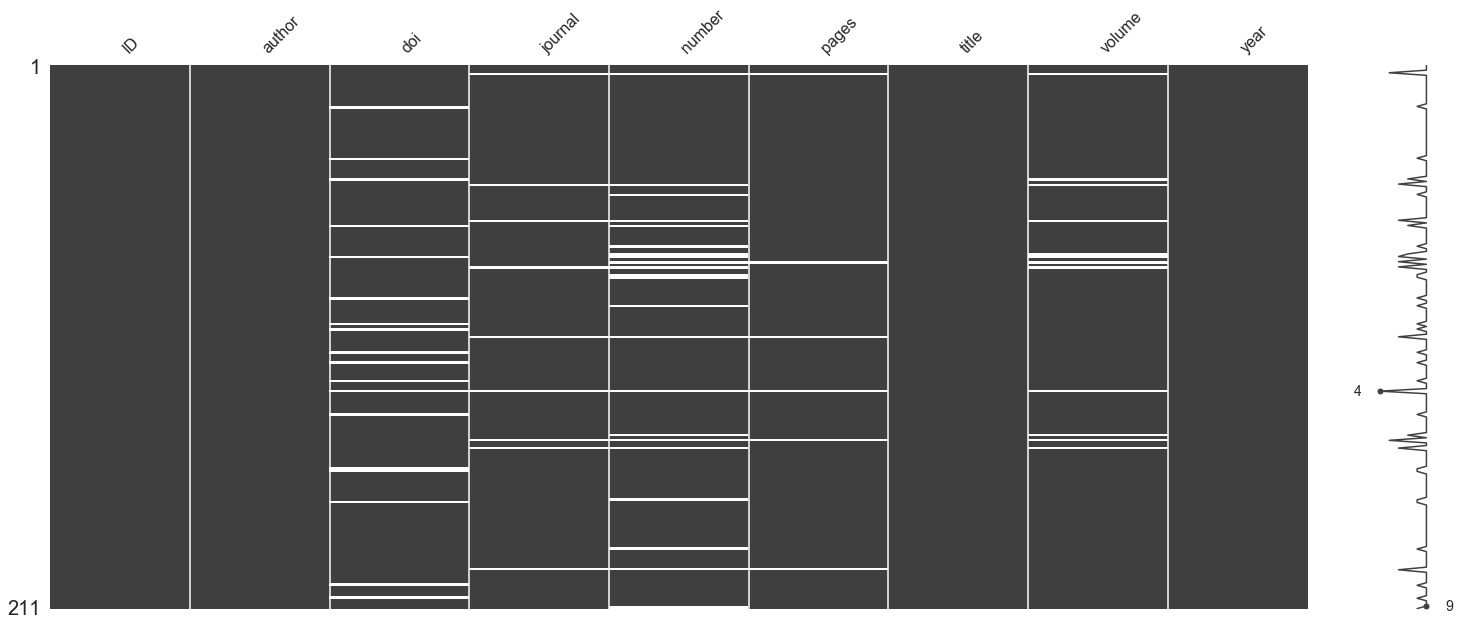

In [16]:
msno.matrix(bib);

In [14]:
# create_photoDB_csv("/Users/iangilman/CAM_database/Abraham2016NatP.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Akhani2007IJPS.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/AlTurki2014JPI.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/ANDERSON1981PCE.csv") No data of interest
# create_photoDB_csv("/Users/iangilman/CAM_database/Aragon2013PCR.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Arroyo1990BA.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/BarreraZambrano2014JXB.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bender1973PPhys.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bender1973JBGS.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bender1971PhyC.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bender1968RC.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bohley2015PPEES.csv")
# create_photoDB_csv("/Users/iangilman/CAM_database/Bone2015NewPhy.csv")
# create_photoDB_csv("/Users/iangilman/Dropbox/CAM_database/Bruhl2007A.csv")

In [240]:
Eriocoma_cuspidata = Species(genus="Eriocoma", epithet="cuspidata")

In [244]:
Eriocoma_cuspidata.check_status()

In [245]:
Eriocoma_cuspidata.status

'Synonym'

In [429]:
species_list = ["Eriocoma cuspidata", "Oryzopsis hymenoides", "Portulaca oleracea", "Zygocactus truncatus",
               "Portulaca pilosa"]

In [369]:
url = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format("Portulaca oleracea")
response = requests.get(url)
soup = BeautifulSoup(response.text, "lxml")
result = soup.find_all("p")
status_line = str(BeautifulSoup(result[0].text, "lxml").find_all('p')[0].text)

In [476]:
for species in species_list:
    print(species)
    url = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format(species)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
    result = soup.find_all("p")
    status_line = str(BeautifulSoup(result[0].text, "lxml").find_all('p')[0].text)
    
    # Look for accepted in line
    if "accepted" in status_line:
        print("This is an accepted name")

    # If taxon is synonym of another accepted taxon
    elif "synonym" in status_line:
        print("This is a known synonym")
        # Look for first uppercase that doesn't start sentence
        splitstatus = status_line.split()[1:]
        for i, word in enumerate(splitstatus):
            if word[0].isupper():
                updated_genus = str(word)
                updated_epithet = str(splitstatus[i+1])
                # Check for intraspecifics
                try:
                    if splitname[i+2] in ["f.", "subsp.", "var."]:
                        updated_subspecies = splitname[i+3]
                        updated_authority = str(status_line.split(updated_subspecies)[-1].strip())
                        # Solves a problem when no authority exists
                        if (updated_authority==subspecies) or (updated_authority in ["f.", "subsp.", "var."]):
                            updated_authority = ""
                    else:
                        updated_subspecies = ""
                        updated_authority = str(status_line.split(updated_epithet)[-1].strip())
                except IndexError:
                    print("Looks like its time to solve this problem")
                break    
        updated_status = "Accepted"

    # If there are multiple records we need to parse
    elif status_line[0].isdigit():
        print("Multiple records found")
        # Parse HTML table with BS4
        table = soup.find_all("table", attrs={"class":"names results"})
        rows = table[0].find_all("tr")
        data = []
        for row in rows:
            cols = [ele.text.strip() for ele in row.find_all('td')]
            data.append([ele for ele in cols if ele]) # Get rid of empty values  
        data.pop(0) # First element is always empty list

        records = []
        for i in range(len(data)):
            name = data[i][0]
            splitname = name.split()
            updated_genus = splitname[0]
            updated_epithet = splitname[1]
            updated_status = data[i][1]
            # Check for intraspecifics
            if splitname[2] in ["f.", "subsp.", "var."]:
                updated_subspecies = splitname[3]
                updated_authority = name.split(updated_subspecies)[1].strip()
                # Solves a problem when no authority exists
                if (updated_authority==updated_subspecies) or (updated_authority in ["f.", "subsp.", "var."]):
                    updated_authority = ""
            else:
                updated_subspecies = ""
                updated_uthority = name.split(updated_epithet)[1].strip()
            records.append([updated_genus, updated_epithet, updated_subspecies, updated_authority, updated_status])

        records_df = pd.DataFrame(data=records, columns=["Genus", "Epithet", "Subspecies", "Authority", "Status"])
        
        if len(records_df.loc[records_df["Status"]=="Accepted"])==1:
        # Single accepted name found
            print("\tA single accepted name was found")
            updated_genus = str(records_df.loc[records_df["Status"]=="Accepted", "Genus"].item())
            updated_epithet = str(records_df.loc[records_df["Status"]=="Accepted", "Epithet"].item())
            updated_subspecies = str(records_df.loc[records_df["Status"]=="Accepted", "Subspecies"].item())
            updated_status = str(records_df.loc[records_df["Status"]=="Accepted", "Status"].item())
            updated_authority = str(records_df.loc[records_df["Status"]=="Accepted", "Authority"].item())
        # Multiple accepted names found
        elif len(records_df.loc[records_df["Status"]=="Accepted"])>1:
            print("\tMultiple accepted names were found")
            accepted_df = records_df.loc[records_df["Status"]=="Accepted"].copy()
            accepted_df["longname"] = [' '.join(row[["Genus", "Epithet", "Subspecies"]]) for i, row in accepted_df.iterrows()]
            # Case where accepted names are species and intraspecifics
            if long_substr(accepted_df["longname"]) in list(accepted_df["longname"]):
                updated_genus = str(accepted_df.loc[accepted_df["longname"]==long_substr(accepted_df["longname"]), "Genus"].item())
                updated_epithet = str(accepted_df.loc[accepted_df["longname"]==long_substr(accepted_df["longname"]), "Epithet"].item())
                updated_subspecies = str(accepted_df.loc[accepted_df["longname"]==long_substr(accepted_df["longname"]), "Subspecies"].item())
                updated_status = str(accepted_df.loc[accepted_df["longname"]==long_substr(accepted_df["longname"]), "Status"].item())
                updated_authority = str(accepted_df.loc[accepted_df["longname"]==long_substr(accepted_df["longname"]), "Authority"].item())
         
        elif len(records_df.loc[records_df["Status"]=="Accepted"])<1:
            print("\tNo accepted names were found")
            syn_df = records_df.loc[records_df["Status"]=="Synonym"].copy()
            syn_df["longname"] = [' '.join(row[["Genus", "Epithet", "Subspecies"]]) for i, row in syn_df.iterrows()]
            # Case where accepted names are species and intraspecifics
            if long_substr(syn_df["longname"]) in list(syn_df["longname"]):
                updated_genus = str(syn_df.loc[syn_df["longname"]==long_substr(syn_df["longname"]), "Genus"].item())
                updated_epithet = str(syn_df.loc[syn_df["longname"]==long_substr(syn_df["longname"]), "Epithet"].item())
                updated_subspecies = str(syn_df.loc[syn_df["longname"]==long_substr(syn_df["longname"]), "Subspecies"].item())
                updated_status = str(syn_df.loc[syn_df["longname"]==long_substr(syn_df["longname"]), "Status"].item())
                updated_authority = str(syn_df.loc[syn_df["longname"]==long_substr(syn_df["longname"]), "Authority"].item())
    print(updated_genus, updated_epithet, updated_subspecies, updated_authority, updated_status)


Eriocoma cuspidata
This is a known synonym
('Oryzopsis', 'hymenoides', '', '(Roem. & Schult.) Ricker ex Piper.', 'Accepted')
Oryzopsis hymenoides
Multiple records found
	A single accepted name was found
('Oryzopsis', 'hymenoides', '', '(Roem. & Schult.) Ricker ex Piper.', 'Accepted')
Portulaca oleracea
Multiple records found
	A single accepted name was found
('Portulaca', 'oleracea', '', '(Roem. & Schult.) Ricker ex Piper.', 'Accepted')
Zygocactus truncatus
Multiple records found
	No accepted names were found
('Zygocactus', 'truncatus', '', '(Roem. & Schult.) Ricker ex Piper.', 'Synonym')
Portulaca pilosa
Multiple records found
	Multiple accepted names were found
('Portulaca', 'pilosa', '', '(Roem. & Schult.) Ricker ex Piper.', 'Accepted')


In [464]:
print long_substr(accepted_df["longname"])

Portulaca pilosa 


In [451]:
def long_substr(data):
    substr = ''
    if len(data) > 1 and len(data[0]) > 0:
        for i in range(len(data[0])):
            for j in range(len(data[0])-i+1):
                if j > len(substr) and all(data[0][i:i+j] in x for x in data):
                    substr = data[0][i:i+j]
    return substr

In [452]:
long_substr(["Portulaca  pilosa", "Portulaca  pilosa deipiens", "Portulaca  pilosa procumbens"])

'Portulaca  pilosa'

In [448]:
"Portulaca oleracea" in "Portulaca oleracea subsp. oleracea"

True

In [408]:
if len(syn_df.loc[syn_df["Status"]=="Accepted"])==1:
    updated_genus = syn_df.loc[syn_df["Status"]=="Accepted", "Genus"].item()
    updated_epithet = syn_df.loc[syn_df["Status"]=="Accepted", "Epithet"].item()
    updated_subspecies = syn_df.loc[syn_df["Status"]=="Accepted", "Subspecies"].item()
    updated_status = syn_df.loc[syn_df["Status"]=="Accepted", "Status"].item()
    updated_authority = syn_df.loc[syn_df["Status"]=="Accepted", "Authority"].item()

elif len(syn_df.loc[syn_df["Status"]=="Accepted"])>1:
    

In [410]:
updated_authority

u'L.'

In [388]:
syn_df

,Genus,Epithet,Subspecies,Authority,Status
0,Portulaca,oleracea,,L.,Accepted
1,Portulaca,oleracea,alba,Alef.,Synonym
2,Portulaca,oleracea,aurantia,Alef.,Synonym
3,Portulaca,oleracea,aurea,Alef.,Synonym
4,Portulaca,oleracea,caryophyllina,Alef.,Synonym
5,Portulaca,oleracea,gillesii,Alef.,Synonym
6,Portulaca,oleracea,granulatostellulata,(Poelln.) Danin & H.G.Baker,Synonym
7,Portulaca,oleracea,granulatostellulata,Poelln.,Synonym
8,Portulaca,oleracea,haageana,Alef.,Synonym
9,Portulaca,oleracea,impolita,Danin & H.G.Baker,Unresolved


In [367]:
for name in ['Zygocactus truncatus (Haw.) K.Schum.', 
             'Zygocactus truncatus var. delicatus (N.E. Br.) Backeb. & F.M. Knuth']:
    splitname = name.split()
    genus = splitname[0]
    epithet = splitname[1]
    
    if splitname[2] in ["f.", "subsp.", "var."]:
        subspecies = splitname[3]
        authority = name.split(subspecies)[1].strip()
    else:
        subspecies = None
        authority = name.split(epithet)[1].strip()
    print(genus, epithet, subspecies, authority)

('Zygocactus', 'truncatus', None, '(Haw.) K.Schum.')
('Zygocactus', 'truncatus', 'delicatus', '(N.E. Br.) Backeb. & F.M. Knuth')


In [359]:
data.pop(0)

[]

In [360]:
data

[[u'Zygocactus truncatus (Haw.) K.Schum.',
  u'Synonym',
  u'WCSP (in review)',
  u'2012-03-23'],
 [u'Zygocactus truncatus var. delicatus (N.E. Br.) Backeb. & F.M. Knuth',
  u'Synonym',
  u'TRO',
  u'2012-04-18']]

In [330]:
table

[<table class="names results" id="tbl-results">\n<thead>\n<tr>\n<th>Name</th>\n<th>Status</th>\n<th>Confi\xaddence level</th>\n<th>Source</th>\n<th>Date supplied</th>\n</tr>\n</thead>\n<tbody>\n<tr id="Zygocactus-T">\n<td class="name Synonym"><a href="/tpl1.1/record/kew-2470425"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="authorship">(Haw.) K.Schum.</span></span></a></td>\n<td>Synonym</td>\n<td class="C-M"><img alt="M" src="/1.1/img/M.png"/></td>\n<td class="source"><a href="/1.1/about/#wcsir">WCSP (in review)</a></td>\n<td class="dateExported"><time>2012-03-23</time></td>\n</tr>\n<tr>\n<td class="name Synonym"><a href="/tpl1.1/record/tro-50163817"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="infraspr">var.</span> <i class="infraspe">delicatus</i> <span class="authorship">(N.E. Br.) Backeb. &amp; F.M. Knuth</span></span></a></td>\n<td>Synonym</td>\n<td class="C-L"><img alt="L" src="

In [336]:
table[0].find_all("tr")

[<tr>\n<th>Name</th>\n<th>Status</th>\n<th>Confi\xaddence level</th>\n<th>Source</th>\n<th>Date supplied</th>\n</tr>,
 <tr id="Zygocactus-T">\n<td class="name Synonym"><a href="/tpl1.1/record/kew-2470425"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="authorship">(Haw.) K.Schum.</span></span></a></td>\n<td>Synonym</td>\n<td class="C-M"><img alt="M" src="/1.1/img/M.png"/></td>\n<td class="source"><a href="/1.1/about/#wcsir">WCSP (in review)</a></td>\n<td class="dateExported"><time>2012-03-23</time></td>\n</tr>,
 <tr>\n<td class="name Synonym"><a href="/tpl1.1/record/tro-50163817"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="infraspr">var.</span> <i class="infraspe">delicatus</i> <span class="authorship">(N.E. Br.) Backeb. &amp; F.M. Knuth</span></span></a></td>\n<td>Synonym</td>\n<td class="C-L"><img alt="L" src="/1.1/img/L.png"/></td>\n<td class="source"><a href="/1.1/about/#tropicos">

In [347]:
rows = table[0].find_all("tr")
data = []
for row in rows:
    cols = [ele.text.strip() for ele in row.find_all('td')]
    data.append([ele for ele in cols if ele]) # Get rid of empty values
data

[[],
 [u'Zygocactus truncatus (Haw.) K.Schum.',
  u'Synonym',
  u'WCSP (in review)',
  u'2012-03-23'],
 [u'Zygocactus truncatus var. delicatus (N.E. Br.) Backeb. & F.M. Knuth',
  u'Synonym',
  u'TRO',
  u'2012-04-18']]

In [346]:
table

[<table class="names results" id="tbl-results">\n<thead>\n<tr>\n<th>Name</th>\n<th>Status</th>\n<th>Confi\xaddence level</th>\n<th>Source</th>\n<th>Date supplied</th>\n</tr>\n</thead>\n<tbody>\n<tr id="Zygocactus-T">\n<td class="name Synonym"><a href="/tpl1.1/record/kew-2470425"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="authorship">(Haw.) K.Schum.</span></span></a></td>\n<td>Synonym</td>\n<td class="C-M"><img alt="M" src="/1.1/img/M.png"/></td>\n<td class="source"><a href="/1.1/about/#wcsir">WCSP (in review)</a></td>\n<td class="dateExported"><time>2012-03-23</time></td>\n</tr>\n<tr>\n<td class="name Synonym"><a href="/tpl1.1/record/tro-50163817"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="infraspr">var.</span> <i class="infraspe">delicatus</i> <span class="authorship">(N.E. Br.) Backeb. &amp; F.M. Knuth</span></span></a></td>\n<td>Synonym</td>\n<td class="C-L"><img alt="L" src="

In [146]:
def check_synonymy(species):
    url = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format(species)
    response = requests.get(url)
    html = response.content
    soup = BeautifulSoup(html, "lxml")
    souptext = [line for line in soup.findAll(text=True) if re.match('^[a-zA-Z]+', line) is not None]
    accepted = "Accepted" in souptext
    
    return accepted, souptext, soup

In [144]:
for species in species_list:
    accepted, souptext = check_synonymy(species)
    
    if accepted:
        print("{} was found to be an accepted name.".format(species))
    else: 
        if any([line.startswith("This name is a") for line in souptext]):
            for i, line in enumerate(souptext):
                if (line.startswith("This name is a")) and (souptext[i+1]=="synonym"):
                    syn_genus = souptext[i+2]
                    syn_species = souptext[i+3]
                    synonym = " ".join([syn_genus, syn_species])
                    if check_synonymy(synonym)[0]:
                        print("{} was found to be a synonym of {}".format(species, synonym))
                    else:
                        print("{} was found to be a synonym but we're having trouble finding the accepted name.")
        elif "Results" in souptext:
            print soup


Eriocoma cuspidata was found to be a synonym of Oryzopsis hymenoides
Oryzopsis hymenoides was found to be an accepted name.
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
<title>Search results — The Plant List</title>
<link href="/1.1/opensearch.xml" rel="search" title="The Plant List" type="application/opensearchdescription+xml"/>
<script src="/1.1/img/jquery-1.4.3.min.js" type="text/javascript"></script>
<script src="/1.1/img/jquery.tablesorter.min.js" type="text/javascript"></script>
<!--[if lt IE 9]><script type="text/javascript" src="/1.1/img/html5.js"></script><![endif]-->
<script src="/1.1/img/bsn.AutoSuggest_2.1.3.js" type="text/javascript"></script>
<script src="/1.1/img/tpl.js" type="text/javascript"></script>
<link href="/1.1/img/tpl.css" rel="stylesheet"/>
<!--[if lt IE 9]><link rel="stylesheet" href="/1.1/img/tpl-ie8.css"/><![endif]-->
<!--[if lt IE 8]><link rel="stylesheet" href="/1.1/img/tpl-ie7.css"

In [195]:
url = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format("Zygocactus truncatus")
response = requests.get(url)
html = response.content
soup = BeautifulSoup(html, "lxml")
table = soup.find_all("table")

In [211]:
tags = soup.find_all('a')

In [222]:
for tag in tags:
    if "Zygocactus" in tag.text: 
        print tag.attrs['href']

/tpl1.1/record/kew-2470425
/tpl1.1/record/tro-50163817


In [189]:
for i, line in enumerate(str(table[0]).split("\n")):
    if "name Synonym" in line:
        print re.split(r'[""]', line)[3]
        print line
        newsoup = BeautifulSoup(line, 'lxml')
        mylink = newsoup.find('a')

/tpl1.1/record/kew-2470425
<td class="name Synonym"><a href="/tpl1.1/record/kew-2470425"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="authorship">(Haw.) K.Schum.</span></span></a></td>
/tpl1.1/record/tro-50163817
<td class="name Synonym"><a href="/tpl1.1/record/tro-50163817"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="infraspr">var.</span> <i class="infraspe">delicatus</i> <span class="authorship">(N.E. Br.) Backeb. &amp; F.M. Knuth</span></span></a></td>


In [191]:
mylink.attrs

{'href': '/tpl1.1/record/tro-50163817'}

In [184]:
type(mylink)

bs4.element.Tag

In [147]:
accepted, souptext, soup = check_synonymy("Zygocactus truncatus")

In [154]:
?soup.find_all()

In [152]:
for line in str(soup).split("\n"):
    if line.startswith('<td class="name Synonym">'):
        print line

<td class="name Synonym"><a href="/tpl1.1/record/kew-2470425"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="authorship">(Haw.) K.Schum.</span></span></a></td>
<td class="name Synonym"><a href="/tpl1.1/record/tro-50163817"><span class="name"><i class="genus">Zygocactus</i> <i class="species">truncatus</i> <span class="infraspr">var.</span> <i class="infraspe">delicatus</i> <span class="authorship">(N.E. Br.) Backeb. &amp; F.M. Knuth</span></span></a></td>


In [132]:
url = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format("Zygocactus truncatus")
response = requests.get(url)
html = response.content
soup = BeautifulSoup(html, "lxml")
souptext = soup.findAll(text=True)

In [135]:
url

'http://www.theplantlist.org/tpl1.1/search?q=Zygocactus truncatus'

In [85]:
url2 = 'http://www.theplantlist.org/tpl1.1/search?q={}'.format(acc)
response2 = requests.get(url2)
html2 = response2.content
soup2 = BeautifulSoup(html2, "lxml")
souptext2 = [line for line in soup2.findAll(text=True) if re.match('^[a-zA-Z]+', line) is not None]

In [84]:
souptext

[u'html',
 u'Eriocoma cuspidata Nutt. \u2014 The Plant List',
 u'The Plant List \u2014 A working list for all plant species',
 u'Home',
 u'About',
 u'Browse',
 u'Statistics',
 u'Feedback',
 u'How to use this site',
 u'The Plant List',
 u'Eriocoma',
 u'cuspidata',
 u'Nutt.',
 u'Eriocoma',
 u'cuspidata',
 u'Nutt.',
 u'is a ',
 u'synonym',
 u'Oryzopsis',
 u'hymenoides',
 u'This name is a ',
 u'synonym',
 u'Oryzopsis',
 u'hymenoides',
 u'The record derives from ',
 u'WCSP',
 u'synonym',
 u'Gen. N. Amer. Pl. 1: 40 1818',
 u'Full publication details for this name can be found in ',
 u'IPNI',
 u'http://ipni.org/urn:lsid:ipni.org:names:325295-2',
 u'Earlier versions',
 u'This name was in version 1 of The Plant List, record ',
 u'kew-413906',
 u'this name record ',
 u'has not',
 u'names related to this name ',
 u'have ',
 u'Terms and Conditions',
 u'How to Cite']

In [86]:
souptext2

[u'html',
 u'Search results \u2014 The Plant List',
 u'The Plant List \u2014 A working list for all plant species',
 u'Home',
 u'About',
 u'Browse',
 u'Statistics',
 u'Feedback',
 u'How to use this site',
 u'Results',
 u'Oryzopsis hymenoides',
 u'The results can also be ',
 u'downloaded as a ',
 u'CSV',
 u'See ',
 u'Name',
 u'Status',
 u'Confi\xaddence level',
 u'Source',
 u'Date supplied',
 u'Oryzopsis',
 u'hymenoides',
 u'Accepted',
 u'WCSP',
 u'Oryzopsis',
 u'hymenoides',
 u'var.',
 u'contracta',
 u'B.L.Johnson',
 u'Synonym',
 u'WCSP',
 u'Oryzopsis',
 u'hymenoides',
 u'var.',
 u'hymenoides',
 u'Synonym',
 u'TRO',
 u'tplTableInit("tbl-results");',
 u'Terms and Conditions',
 u'How to Cite']

In [78]:
for line in souptext2:
    try:
        if line.split()[0].isalpha():
            print line
    except IndexError:
        next

html
Search results — The Plant List
The Plant List — A working list for all plant species
Home
About
Browse
Statistics
Feedback
How to use this site
Results
Oryzopsis hymenoides
The results can also be 
downloaded as a 
CSV
 file
See 
 for definitions.
Name
Status
Source
Date supplied
Oryzopsis
hymenoides
Accepted
WCSP
Oryzopsis
hymenoides
contracta
Synonym
WCSP
Oryzopsis
hymenoides
hymenoides
Synonym
TRO
Terms and Conditions
How to Cite

try {
	reinvigorate.track("qqd10-7tcw301jmk");
} catch(err) {}



In [68]:
for line in souptext:
    try:
        if line.split()[0].isalpha():
            print line
    except IndexError:
        next

html
Eriocoma cuspidata Nutt. — The Plant List
The Plant List — A working list for all plant species
Home
About
Browse
Statistics
Feedback
How to use this site
The Plant List
Eriocoma
cuspidata
Eriocoma
cuspidata
is a 
synonym

 of 
Oryzopsis
hymenoides
This name is a 
synonym
 of 
Oryzopsis
hymenoides
The record derives from 
WCSP
synonym
Full publication details for this name can be found in 
IPNI
Earlier versions
This name was in version 1 of The Plant List, record 
this name record 
has not
 changed
names related to this name 
have 
 changed
Terms and Conditions
How to Cite

try {
	reinvigorate.track("qqd10-7tcw301jmk");
} catch(err) {}



In [50]:
str(soup)

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="utf-8"/>\n<meta content="IE=Edge" http-equiv="X-UA-Compatible"/>\n<title>Eriocoma cuspidata Nutt. \xe2\x80\x94 The Plant List</title>\n<link href="/1.1/opensearch.xml" rel="search" title="The Plant List" type="application/opensearchdescription+xml"/>\n<script src="/1.1/img/jquery-1.4.3.min.js" type="text/javascript"></script>\n<script src="/1.1/img/jquery.tablesorter.min.js" type="text/javascript"></script>\n<!--[if lt IE 9]><script type="text/javascript" src="/1.1/img/html5.js"></script><![endif]-->\n<script src="/1.1/img/bsn.AutoSuggest_2.1.3.js" type="text/javascript"></script>\n<script src="/1.1/img/tpl.js" type="text/javascript"></script>\n<link href="/1.1/img/tpl.css" rel="stylesheet"/>\n<!--[if lt IE 9]><link rel="stylesheet" href="/1.1/img/tpl-ie8.css"/><![endif]-->\n<!--[if lt IE 8]><link rel="stylesheet" href="/1.1/img/tpl-ie7.css"/><![endif]-->\n<!--[if lt IE 7]><link rel="stylesheet" href="/1.1/img/tpl-ie6.css"/><![

In [49]:
re.sub(r'([^\s\w]|_)+', '', str(soup)).splitlines()

['DOCTYPE html',
 'html langen',
 'head',
 'meta charsetutf8',
 'meta contentIEEdge httpequivXUACompatible',
 'titleEriocoma cuspidata Nutt  The Plant Listtitle',
 'link href11opensearchxml relsearch titleThe Plant List typeapplicationopensearchdescriptionxml',
 'script src11imgjquery143minjs typetextjavascriptscript',
 'script src11imgjquerytablesorterminjs typetextjavascriptscript',
 'if lt IE 9script typetextjavascript src11imghtml5jsscriptendif',
 'script src11imgbsnAutoSuggest213js typetextjavascriptscript',
 'script src11imgtpljs typetextjavascriptscript',
 'link href11imgtplcss relstylesheet',
 'if lt IE 9link relstylesheet href11imgtplie8cssendif',
 'if lt IE 8link relstylesheet href11imgtplie7cssendif',
 'if lt IE 7link relstylesheet href11imgtplie6cssendif',
 'head',
 'body',
 'header',
 'h1a hrefThe Plant List  A working list for all plant speciesah1',
 'form actiontpl11search idheaderSearchForm methodget',
 'input idq nameq placeholderEnter a genus or genus and species size

In [45]:
for line in re.split(r"[><]", str(soup)):
    print line


!DOCTYPE html


html lang="en"


head


meta charset="utf-8"/


meta content="IE=Edge" http-equiv="X-UA-Compatible"/


title
Eriocoma cuspidata Nutt. — The Plant List
/title


link href="/1.1/opensearch.xml" rel="search" title="The Plant List" type="application/opensearchdescription+xml"/


script src="/1.1/img/jquery-1.4.3.min.js" type="text/javascript"

/script


script src="/1.1/img/jquery.tablesorter.min.js" type="text/javascript"

/script


!--[if lt IE 9]

script type="text/javascript" src="/1.1/img/html5.js"

/script

![endif]--


script src="/1.1/img/bsn.AutoSuggest_2.1.3.js" type="text/javascript"

/script


script src="/1.1/img/tpl.js" type="text/javascript"

/script


link href="/1.1/img/tpl.css" rel="stylesheet"/


!--[if lt IE 9]

link rel="stylesheet" href="/1.1/img/tpl-ie8.css"/

![endif]--


!--[if lt IE 8]

link rel="stylesheet" href="/1.1/img/tpl-ie7.css"/

![endif]--


!--[if lt IE 7]

link rel="stylesheet" href="/1.1/img/tpl-ie6.css"/

![endif]--


/head


body


h

In [ ]:
data = []
for tr in table:
    td = tr.find_all('td')
    row = [i.text for i in td]
    data.append(row)
data = np.array(data)

## Load CAM database

In [2]:
CAM_DB = pd.read_csv('/Users/iangilman/GitHub/photo_db/CAM_database.csv')
CAM_DB.drop(labels=["Unnamed: 0"], axis=1, inplace=True)
CAM_DB.head()

,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,BS_area_um2,FM_DM,FM_DM_sd,...,avg_elevation_m,LCCDM,SLAFM,tissue,long_name,pct_night_C02,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd
0,Orchidaceae,NaN,NaN,NaN,Acineta,sp.,NaN,NaN,7.1,0.3,...,NaN,NaN,NaN,NaN,Acineta sp.,NaN,NaN,NaN,NaN,NaN
1,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Ada,allenii,NaN,NaN,8.1,0.5,...,NaN,NaN,NaN,NaN,Ada allenii,NaN,NaN,NaN,NaN,NaN
2,Orchidaceae,NaN,NaN,NaN,Ancipitia,crocodiliceps,NaN,NaN,8.7,0.9,...,NaN,NaN,NaN,NaN,Ancipitia crocodiliceps,NaN,NaN,NaN,NaN,NaN
3,Orchidaceae,Epidendroideae,Arethuseae,Arethusinae,Arundina,graminifolia,NaN,NaN,3.5,0.2,...,NaN,NaN,NaN,NaN,Arundina graminifolia,NaN,NaN,NaN,NaN,NaN
4,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,epidendroides,NaN,NaN,5.3,0.2,...,NaN,NaN,NaN,NaN,Aspasia epidendroides,NaN,NaN,NaN,NaN,NaN


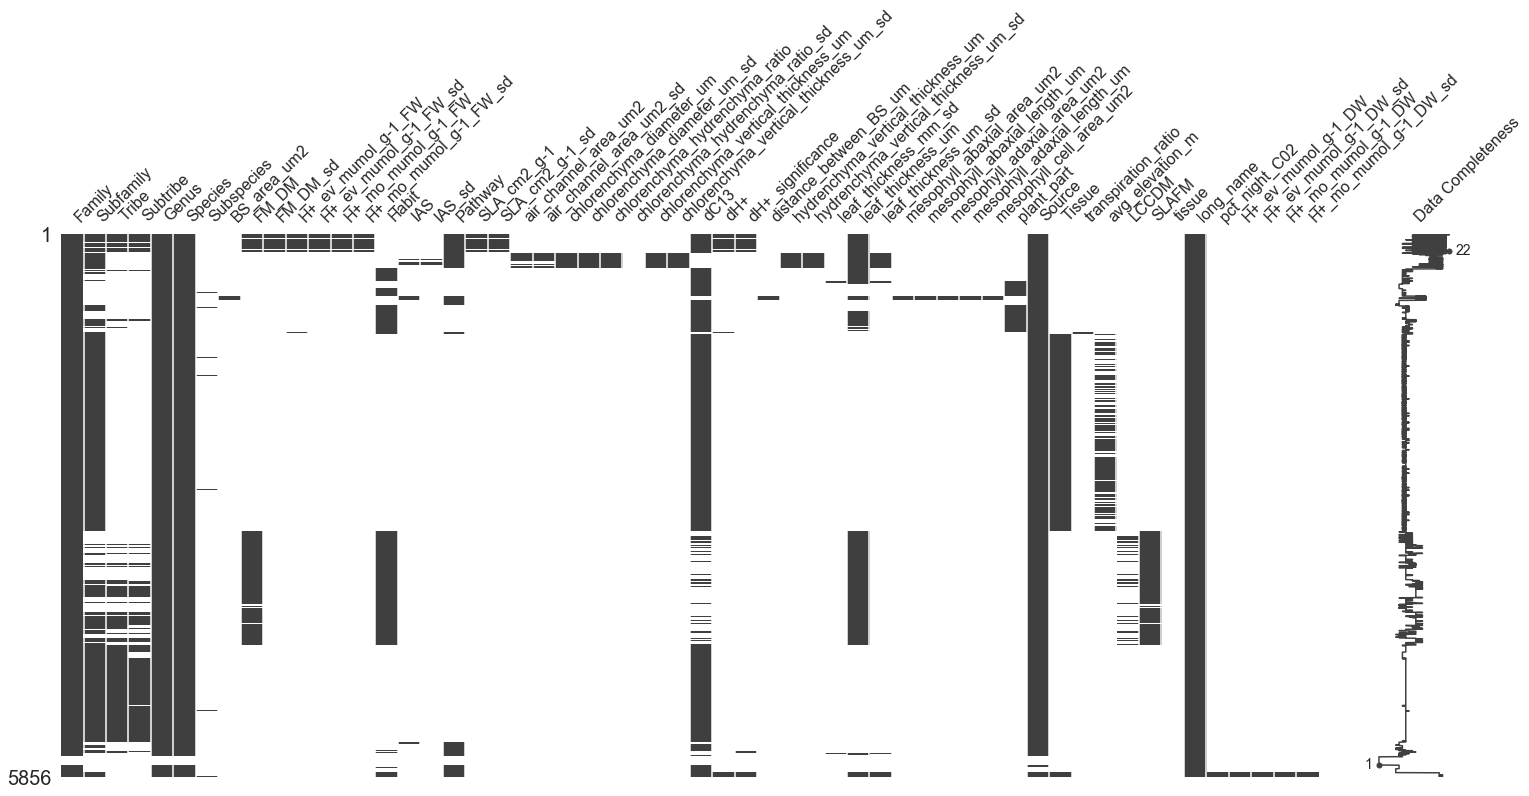

In [282]:
msno.matrix(CAM_DB, labels=True)

In [302]:
CAM_DB.loc[CAM_DB["mesophyll_abaxial_length_um"]>0][["mesophyll_abaxial_length_um", "mesophyll_adaxial_length_um"]]

,mesophyll_abaxial_length_um,mesophyll_adaxial_length_um
673,365.133000,391.080333
675,293.886000,NaN
676,234.482333,NaN
677,332.180367,405.316000
678,238.602967,305.233333
679,120.898667,152.987333
680,86.581333,132.055000
681,110.309667,141.628667
682,124.142667,132.054667
683,114.551000,134.596333


In [44]:
db_taxon_counts(CAM_DB)

The CAM database consists of:
	5856 observations                                        
	60 families                                        
	13 subfamiles                                        
	14 tribes                                        
	23 subtribes                                        
	448 genera                                        
	3807 species


# Add Pierce et al 2002

In [11]:
pierce_etal_2002 = pd.DataFrame.from_csv('./Pierce_etal_2002.csv', index_col=None)
pierce_etal_2002.replace(to_replace={'Habit': {'1': "terrestrial", "2": "terrestrial, tank", 
                                               "3": "terrestrial, epiphyte, tank", "4":"epiphyte, tank",
                                              "5":"epiphyte, lithophyte", "4-5":"epiphyte, lithophyte, tank"}},
                        inplace=True)
pierce_etal_2002.drop(labels=['leaf_thickness_mm', 'leaf_thickness_mm_sd'], axis=1, inplace=True)
pierce_etal_2002.head()

,Family,Subfamily,Genus,Species,Subspecies,Habit,Pathway,dC13,dH+_significance,pct_night_C02,leaf_thickness_um,leaf_thickness_um_sd,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd,dH+,Source,Tissue
0,Bromeliaceae,Bromelioideae,Ronnbergia,explodens,NaN,terrestrial,C3-CAM,-25.4,1,8.8,370,10,0.13,0.02,0.25,0.02,0.12,Pierce et al (2002),leaf
1,Bromeliaceae,Bromelioideae,Neoregelia,concentrica,NaN,"terrestrial, epiphyte, tank",CAM,-13.6,1,59.9,750,30,0.14,0.02,1.43,0.07,1.29,Pierce et al (2002),leaf
2,Bromeliaceae,Bromelioideae,Aechmea,allenii,NaN,"terrestrial, epiphyte, tank",CAM,-15.6,1,68.2,540,20,0.21,0.01,0.96,0.08,0.75,Pierce et al (2002),leaf
3,Bromeliaceae,Bromelioideae,Cryptanthus,colnagoi,NaN,terrestrial,CAM,-15.4,1,75.8,1420,140,0.24,0.05,0.42,0.03,0.18,Pierce et al (2002),leaf
4,Bromeliaceae,Bromelioideae,Orthophytum,magalhaesii,NaN,terrestrial,CAM,-16.3,1,80.5,2130,200,1.09,0.16,5.79,0.52,4.70,Pierce et al (2002),leaf


In [12]:
long_names = []
for i, row in pierce_etal_2002.iterrows():
    try:
        ln = '_'.join(list(row.loc[['Genus', 'Species', 'Subspecies']]))
    except TypeError:
        ln = '_'.join(list(row.loc[['Genus', 'Species']]))
    long_names.append(ln)
pierce_etal_2002['long_name'] = long_names

In [13]:
len(pierce_etal_2002)

50

In [14]:
CAM_DB = CAM_DB.merge(right=pierce_etal_2002, how='outer')

In [15]:
db_taxon_counts(CAM_DB)

The CAM database consists of:
	5856 observations                                        
	60 families                                        
	16 subfamiles                                        
	14 tribes                                        
	23 subtribes                                        
	448 genera                                        
	3807 species


In [16]:
CAM_DB

,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,BS_area_um2,FM_DM,FM_DM_sd,...,avg_elevation_m,LCCDM,SLAFM,tissue,long_name,pct_night_C02,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd
0,Orchidaceae,NaN,NaN,NaN,Acineta,sp.,NaN,NaN,7.1,0.3,...,NaN,NaN,NaN,NaN,Acineta sp.,NaN,NaN,NaN,NaN,NaN
1,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Ada,allenii,NaN,NaN,8.1,0.5,...,NaN,NaN,NaN,NaN,Ada allenii,NaN,NaN,NaN,NaN,NaN
2,Orchidaceae,NaN,NaN,NaN,Ancipitia,crocodiliceps,NaN,NaN,8.7,0.9,...,NaN,NaN,NaN,NaN,Ancipitia crocodiliceps,NaN,NaN,NaN,NaN,NaN
3,Orchidaceae,Epidendroideae,Arethuseae,Arethusinae,Arundina,graminifolia,NaN,NaN,3.5,0.2,...,NaN,NaN,NaN,NaN,Arundina graminifolia,NaN,NaN,NaN,NaN,NaN
4,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,epidendroides,NaN,NaN,5.3,0.2,...,NaN,NaN,NaN,NaN,Aspasia epidendroides,NaN,NaN,NaN,NaN,NaN
5,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,principissa,NaN,NaN,4.5,0.2,...,NaN,NaN,NaN,NaN,Aspasia principissa,NaN,NaN,NaN,NaN,NaN
6,Orchidaceae,Epidendroideae,Calypsoeae,Laeliinae,Brassavola,acaulis,NaN,NaN,16.9,0.2,...,NaN,NaN,NaN,NaN,Brassavola acaulis,NaN,NaN,NaN,NaN,NaN
7,Orchidaceae,Epidendroideae,Calypsoeae,Laeliinae,Brassavola,nodosa,NaN,NaN,12.5,0.5,...,NaN,NaN,NaN,NaN,Brassavola nodosa,NaN,NaN,NaN,NaN,NaN
8,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Brassia,arcuigera,NaN,NaN,5.3,0.3,...,NaN,NaN,NaN,NaN,Brassia arcuigera,NaN,NaN,NaN,NaN,NaN
9,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Brassia,caudata,NaN,NaN,5.5,0.3,...,NaN,NaN,NaN,NaN,Brassia caudata,NaN,NaN,NaN,NaN,NaN


In [18]:
CAM_DB['Family'], CAM_DB['Subfamily'], CAM_DB['Tribe'], CAM_DB['Subtribe'] = fill_taxonomy(CAM_DB)

In [63]:
CAM_DB["Source"]

0       Silvera et al (2005)
1       Silvera et al (2005)
2       Silvera et al (2005)
3       Silvera et al (2005)
4       Silvera et al (2005)
5       Silvera et al (2005)
6       Silvera et al (2005)
7       Silvera et al (2005)
8       Silvera et al (2005)
9       Silvera et al (2005)
10      Silvera et al (2005)
11      Silvera et al (2005)
12      Silvera et al (2005)
13      Silvera et al (2005)
14      Silvera et al (2005)
15      Silvera et al (2005)
16      Silvera et al (2005)
17      Silvera et al (2005)
18      Silvera et al (2005)
19      Silvera et al (2005)
20      Silvera et al (2005)
21      Silvera et al (2005)
22      Silvera et al (2005)
23      Silvera et al (2005)
24      Silvera et al (2005)
25      Silvera et al (2005)
26      Silvera et al (2005)
27      Silvera et al (2005)
28      Silvera et al (2005)
29      Silvera et al (2005)
                ...         
5826     Pierce et al (2002)
5827     Pierce et al (2002)
5828     Pierce et al (2002)
5829     Pierc

In [29]:
save_CAM_DB(CAM_df=CAM_DB)

In [65]:
?pd.DataFrame.iloc

In [70]:
for index, row in CAM_DB.loc[CAM_DB['Source']=='Silvera et al (2005)'].iterrows():
    if row['dC13'] > -22:
        CAM_DB.iloc[index, CAM_DB.columns.get_loc('Pathway')] = 'CAM'
    else:
        if row['dH+_significance'] > 0:
            CAM_DB.iloc[index, CAM_DB.columns.get_loc('Pathway')] = 'C3-CAM'
        else:
            CAM_DB.iloc[index, CAM_DB.columns.get_loc('Pathway')] = 'C3'

In [72]:
CAM_DB.loc[CAM_DB['Source']=='Silvera et al (2005)']

,Family,Subfamily,Tribe,Subtribe,Genus,Species,Subspecies,BS_area_um2,FM_DM,FM_DM_sd,...,avg_elevation_m,LCCDM,SLAFM,tissue,long_name,pct_night_C02,H+_ev_mumol_g-1_DW,H+_ev_mumol_g-1_DW_sd,H+_mo_mumol_g-1_DW,H+_mo_mumol_g-1_DW_sd
0,Orchidaceae,NaN,NaN,NaN,Acineta,sp.,NaN,NaN,7.1,0.3,...,NaN,NaN,NaN,NaN,Acineta sp.,NaN,NaN,NaN,NaN,NaN
1,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Ada,allenii,NaN,NaN,8.1,0.5,...,NaN,NaN,NaN,NaN,Ada allenii,NaN,NaN,NaN,NaN,NaN
2,Orchidaceae,NaN,NaN,NaN,Ancipitia,crocodiliceps,NaN,NaN,8.7,0.9,...,NaN,NaN,NaN,NaN,Ancipitia crocodiliceps,NaN,NaN,NaN,NaN,NaN
3,Orchidaceae,Epidendroideae,Arethuseae,Arethusinae,Arundina,graminifolia,NaN,NaN,3.5,0.2,...,NaN,NaN,NaN,NaN,Arundina graminifolia,NaN,NaN,NaN,NaN,NaN
4,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,epidendroides,NaN,NaN,5.3,0.2,...,NaN,NaN,NaN,NaN,Aspasia epidendroides,NaN,NaN,NaN,NaN,NaN
5,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Aspasia,principissa,NaN,NaN,4.5,0.2,...,NaN,NaN,NaN,NaN,Aspasia principissa,NaN,NaN,NaN,NaN,NaN
6,Orchidaceae,Epidendroideae,Calypsoeae,Laeliinae,Brassavola,acaulis,NaN,NaN,16.9,0.2,...,NaN,NaN,NaN,NaN,Brassavola acaulis,NaN,NaN,NaN,NaN,NaN
7,Orchidaceae,Epidendroideae,Calypsoeae,Laeliinae,Brassavola,nodosa,NaN,NaN,12.5,0.5,...,NaN,NaN,NaN,NaN,Brassavola nodosa,NaN,NaN,NaN,NaN,NaN
8,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Brassia,arcuigera,NaN,NaN,5.3,0.3,...,NaN,NaN,NaN,NaN,Brassia arcuigera,NaN,NaN,NaN,NaN,NaN
9,Orchidaceae,Epidendroideae,Cymbidieae,Oncidiinae,Brassia,caudata,NaN,NaN,5.5,0.3,...,NaN,NaN,NaN,NaN,Brassia caudata,NaN,NaN,NaN,NaN,NaN


In [73]:
save_CAM_DB(CAM_df=CAM_DB)

In [49]:
CAM_DB['Source']

0       Silvera et al (2005)
1       Silvera et al (2005)
2       Silvera et al (2005)
3       Silvera et al (2005)
4       Silvera et al (2005)
5       Silvera et al (2005)
6       Silvera et al (2005)
7       Silvera et al (2005)
8       Silvera et al (2005)
9       Silvera et al (2005)
10      Silvera et al (2005)
11      Silvera et al (2005)
12      Silvera et al (2005)
13      Silvera et al (2005)
14      Silvera et al (2005)
15      Silvera et al (2005)
16      Silvera et al (2005)
17      Silvera et al (2005)
18      Silvera et al (2005)
19      Silvera et al (2005)
20      Silvera et al (2005)
21      Silvera et al (2005)
22      Silvera et al (2005)
23      Silvera et al (2005)
24      Silvera et al (2005)
25      Silvera et al (2005)
26      Silvera et al (2005)
27      Silvera et al (2005)
28      Silvera et al (2005)
29      Silvera et al (2005)
                ...         
5826     Pierce et al (2002)
5827     Pierce et al (2002)
5828     Pierce et al (2002)
5829     Pierc